# Data Loading and Plotting example

In [1]:
%matplotlib inline
import sys 

sys.path.insert(0,'..')
from utils import plot_stroke
from models.generation import ModelGenerator

import keras
from keras import backend as K
from keras.layers import Input, Dense, Activation, TimeDistributed, Lambda, Bidirectional
from keras.layers.merge import add, concatenate
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.layers.recurrent import LSTM, GRU
from keras.optimizers import Adam
import keras.callbacks
from keras.layers import merge

import numpy as np
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.text import Tokenizer
from keras.models import load_model

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import math
import random
import time
import os
import pickle

import tensorflow as tf

Using TensorFlow backend.


\t is the <START\> token and \n is the <END\> token for texts2

In [2]:
strokes = numpy.load('../data/strokes.npy', encoding='latin1')
with open('../data/sentences.txt') as f:
    texts = f.readlines()
# For data normalization, that way all texts ends with new line char
texts[5999] = texts[5999] + '\n'

texts2 = ['\t' + t for t in texts]

### Strokes

Each handwritten sentence is represented as a 2D array with T rows and 3 columns. T is the number of timesteps. The first column represents whether to interrumpt the current stroke (i.e. when the pen is lifted off the paper). The second and third columns represent the relative coordinates of the new point with respect to the last point. Please have a look at the plot_stroke if you want to understand how to plot this sequence.

In [3]:
lens = np.array([s.shape[0] for s in strokes])
# mean_value + 2*sigma cover over 96% of the data. This will be the sequence lenght used below
print(f'Stroke lenght chosen: \t\t\t{int(lens.mean()+2*lens.std())} which covers {np.sum(lens<=(lens.mean()+2*lens.std()))/len(lens):.2f}')

lens2 = np.array([len(sentences_output) for sentences_output in texts2])
print(f'Sentence lenght chosen: \t\t{int(lens2.mean()+2*lens2.std())} which covers {np.sum(lens2<=(lens2.mean()+2*lens2.std()))/len(lens2):.2f}')

lens3 = np.array([stroke_len/sentence_len for stroke_len, sentence_len in zip(lens, lens2)])
print(f'Strokes per char lenght chosen: \t{int(lens3.mean()+2*lens3.std())} which covers {np.sum(lens3 <= (lens3.mean()+2*lens3.std()))/len(lens3):.2f}')


Stroke lenght chosen: 			976 which covers 0.96
Sentence lenght chosen: 		44 which covers 0.97
Strokes per char lenght chosen: 	28 which covers 0.96


## Experiment 1

### Data Preparation

In [ ]:
max_len = False
inverse = True

In [467]:
from keras.preprocessing.text import Tokenizer
# create the tokenizer
t = Tokenizer(char_level=True, lower=False, filters='', )
# fit the tokenizer on the documents
t.fit_on_texts(texts2)
output = t.texts_to_sequences(texts2)

In [21]:
#Helper functions
def sequence_to_onehot():
    return [to_categorical(v, num_classes=len(t.word_index)+1) for v in t.texts_to_sequences(texts2)]
def onehot_to_sequence(values):
    return [np.argmax(v) for v in values]
idx = t.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token != 0]
    return "".join(words)
# tokens_to_string(onehot_to_sequence(output[0]))

padded_input = pad_sequences(strokes, padding='pre', value=0.0, 
                             dtype='float32',
                             maxlen=int(lens.mean()+2*lens.std()), truncating='pre')
output = np.array(sequence_to_onehot())

In [492]:
num_encoder_tokens = padded_input.shape[2] # Pen,X and Y
num_decoder_tokens = output[0].shape[1] #len(t.word_index)+1 # Every possible char
if max_len:
    max_encoder_seq_length = max([len(s) for s in strokes])
    max_decoder_seq_length = max([len(sentences_output) for sentences_output in t.texts_to_sequences(texts2)])
else:
    max_encoder_seq_length = int(lens.mean()+2*lens.std())
    max_decoder_seq_length = int(lens2.mean()+2*lens2.std())
    
print('Number of samples:', len(strokes))
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

decoder_input_data = np.zeros((len(texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')

if not inverse:
    for i, v in enumerate(output):
        for j, v2 in enumerate(v):
            decoder_input_data[i, j, np.argmax(v2)] = 1
            if j > 0:
                decoder_target_data[i,j-1, np.argmax(v2)] = 1
else: #Inverse
    for i, v in enumerate(output):
        for j, v2 in enumerate(v):
            decoder_input_data[i, max_decoder_seq_length-j-1, np.argmax(v2)] = 1
            if j > 0:
                decoder_target_data[i,max_decoder_seq_length-(j+1), np.argmax(v2)] = 1
            
print(f'padded_input.shape = {padded_input.shape}\
\ndecoder_input_data.shape = {decoder_input_data.shape}\
\ndecoder_target_data.shape = {decoder_target_data.shape}')

Number of samples: 6000
Number of unique output tokens: 80
Max sequence length for inputs: 976
Max sequence length for outputs: 44
padded_input.shape = (6000, 976, 3)
decoder_input_data.shape = (6000, 44, 80)
decoder_target_data.shape = (6000, 44, 80)


### Model Preparation, Training and Visualization

In [123]:
class Previewer(keras.callbacks.Callback):
    def __init__(self,inverted=True):
        self.inverted=inverted

    def on_epoch_end(self, epoch, logs={}):
        idx = np.random.randint(low=0,high=len(strokes))
        predictions = self.model.predict([[padded_input[idx]], [decoder_input_data[idx]]])
        stroke = strokes[idx]
        print(stroke.shape)
        text = texts[idx]
        plot_stroke(stroke)
        print('TEXT:', text)
        sequence = []
        for l in predictions[0]:
            sequence.append(np.argmax(l))
        if self.inverted:
            sequence = np.flip(np.array(sequence))
        predicted = tokens_to_string(sequence)
        if predicted.find('\n') > -1:
            print("TEXT:{}".format(predicted[:predicted.index('\n')]))
        else:
            print("TEXT:{}".format(predicted))

Train on 5520 samples, validate on 480 samples
Epoch 1/100
5520/5520 [==============================] - 127s 23ms/step - loss: 0.4377 - acc: 0.1316 - val_loss: 0.0413 - val_acc: 0.2253
(819, 3)


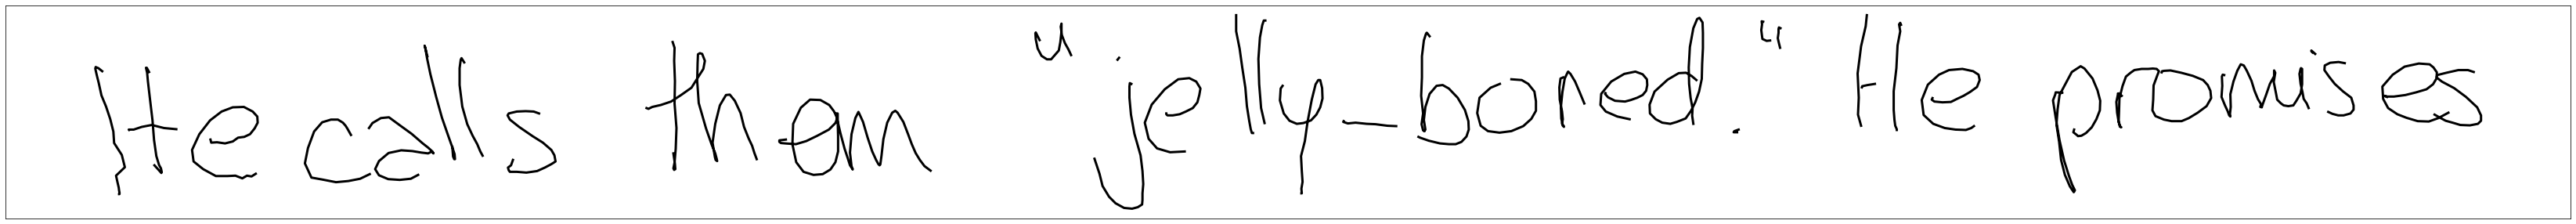

TEXT: He calls them "jelly-boned." He promises

TEXT:pbe calls them "velly boned." be promises


/home/marcos/.local/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer gru_22 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_21/while/Exit_2:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/home/marcos/.local/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer gru_23 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_22/while/Exit_2:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/100
5520/5520 [==============================] - 124s 22ms/step - loss: 0.0212 - acc: 0.2198 - val_loss: 0.0093 - val_acc: 0.2294
(832, 3)


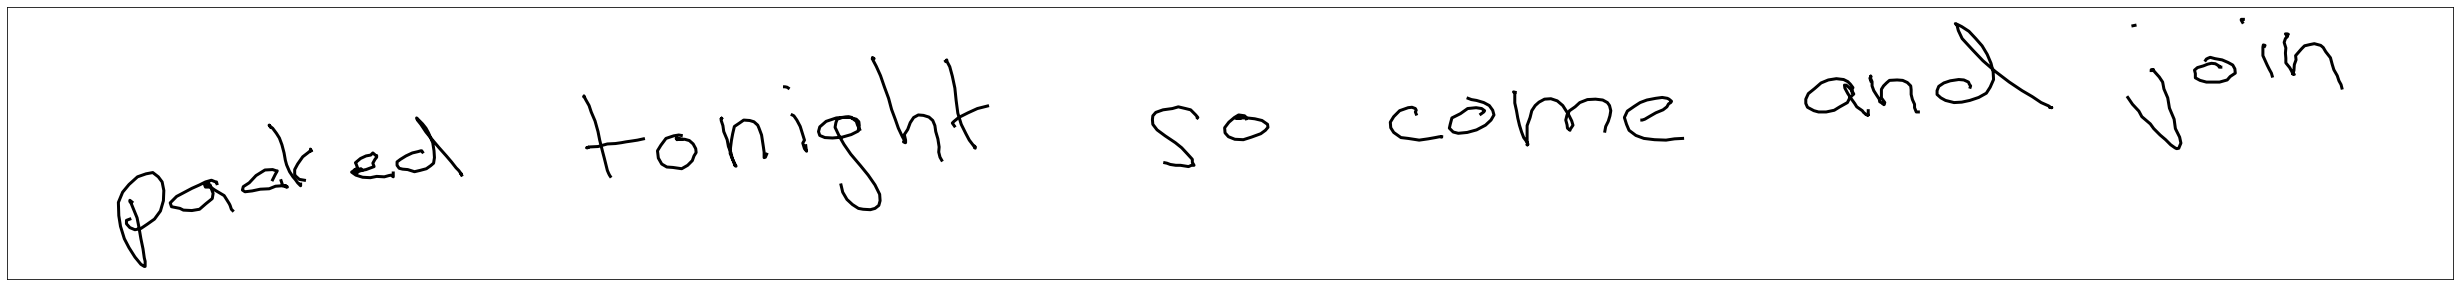

TEXT: packed tonight so come and join

TEXT:
Epoch 3/100
5520/5520 [==============================] - 124s 23ms/step - loss: 0.0061 - acc: 0.2224 - val_loss: 0.0034 - val_acc: 0.2302
(683, 3)


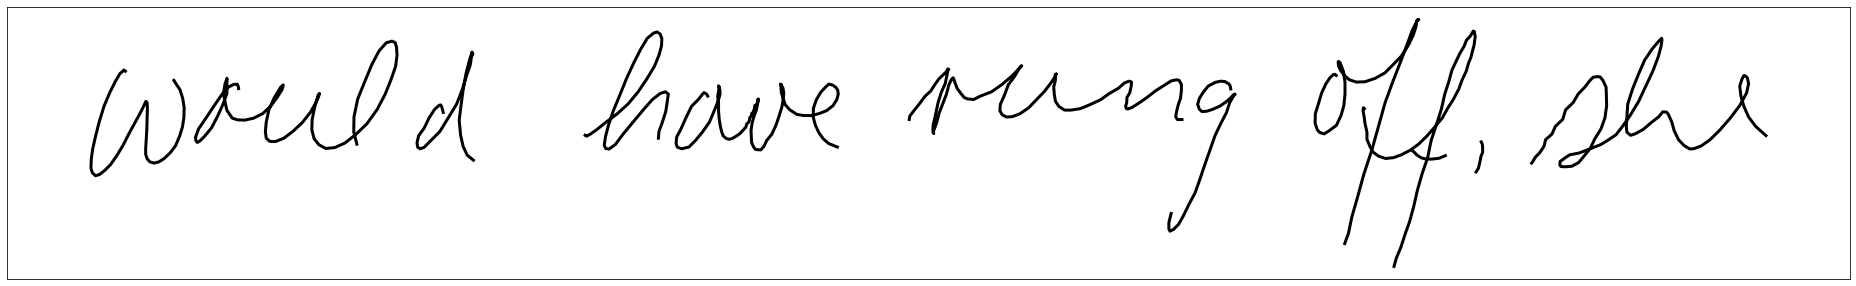

TEXT: would have rung off, she

TEXT: would have rung off, she
Epoch 4/100
5520/5520 [==============================] - 124s 22ms/step - loss: 0.0024 - acc: 0.2228 - val_loss: 0.0015 - val_acc: 0.2303
(509, 3)


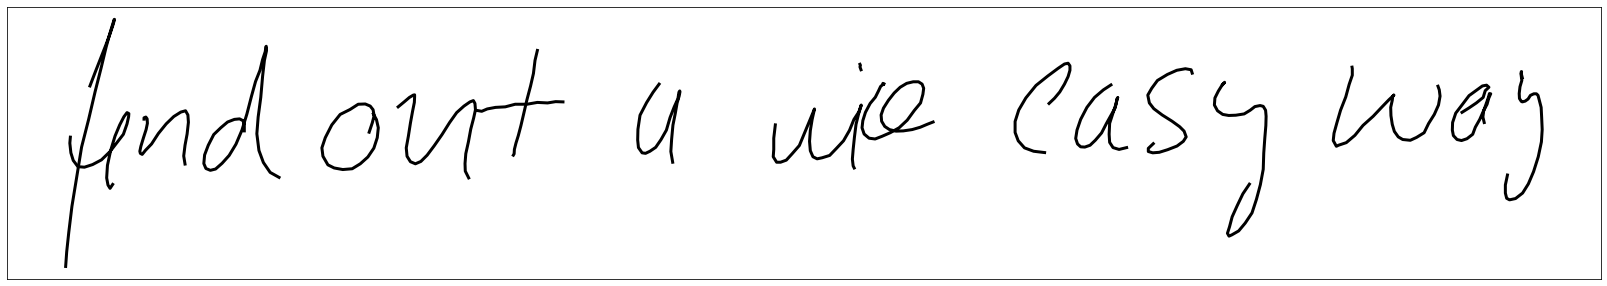

TEXT: find out a nice easy way

TEXT:ofind out a nice easy way
Epoch 5/100
5520/5520 [==============================] - 123s 22ms/step - loss: 0.0011 - acc: 0.2228 - val_loss: 7.1336e-04 - val_acc: 0.2304
(689, 3)


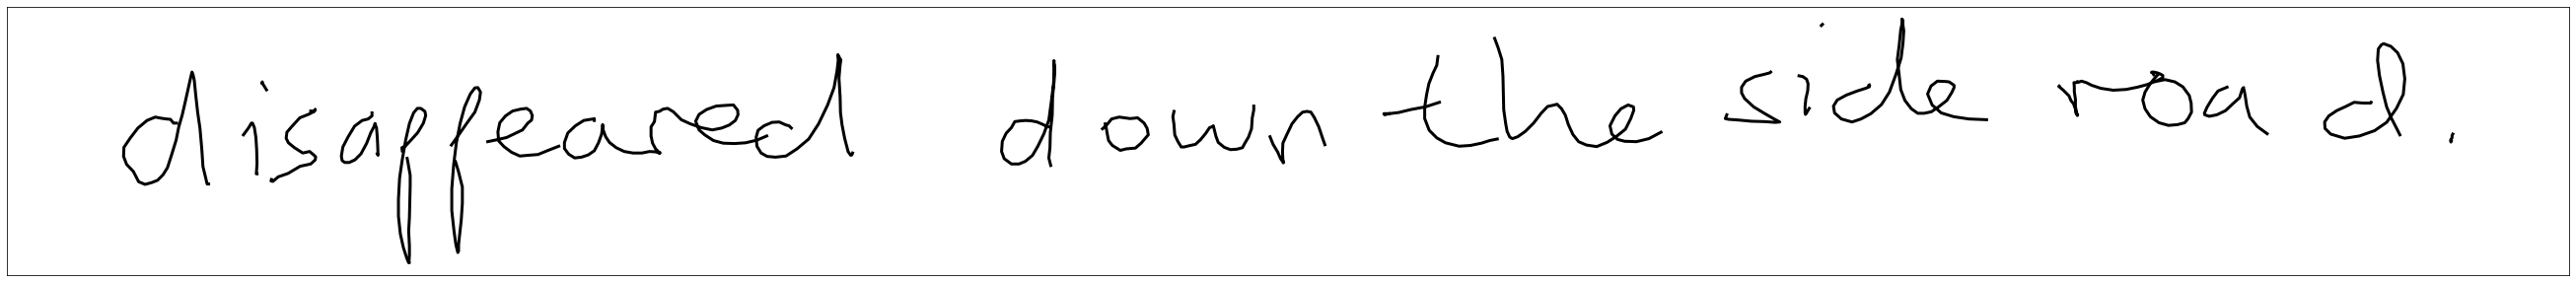

TEXT: disappeared down the side road.

TEXT:adisappeared down the side road.
Epoch 6/100
5520/5520 [==============================] - 123s 22ms/step - loss: 6.6091e-04 - acc: 0.2229 - val_loss: 4.2917e-04 - val_acc: 0.2304
(665, 3)


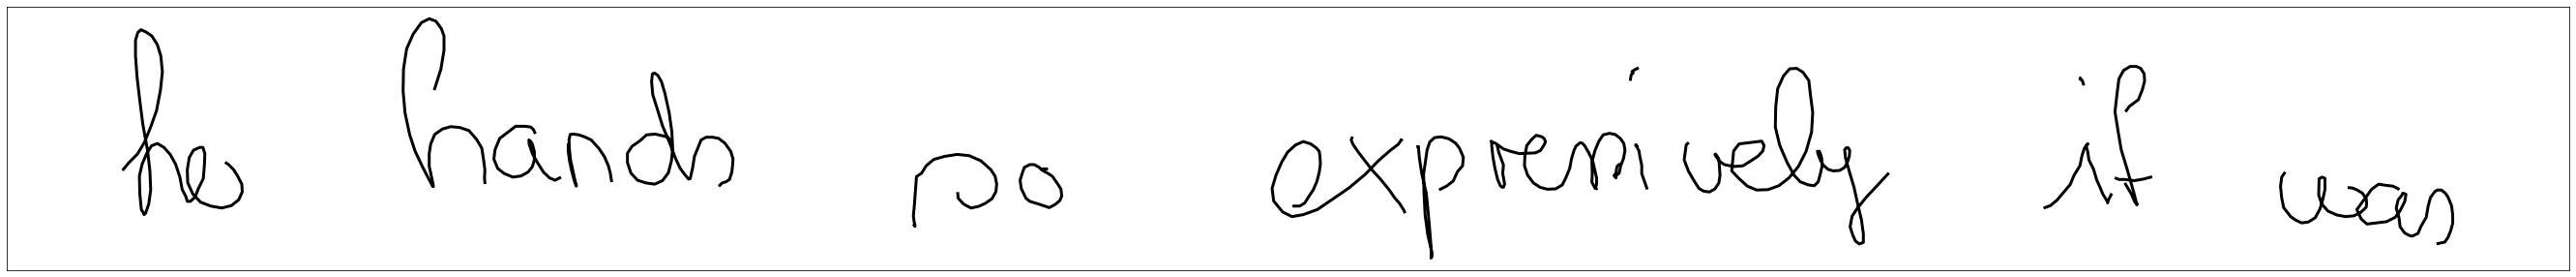

TEXT: her hands so expressively if was

TEXT:ther hands so expressively if was
Epoch 7/100
5520/5520 [==============================] - 123s 22ms/step - loss: 4.2489e-04 - acc: 0.2229 - val_loss: 2.9176e-04 - val_acc: 0.2304
(544, 3)


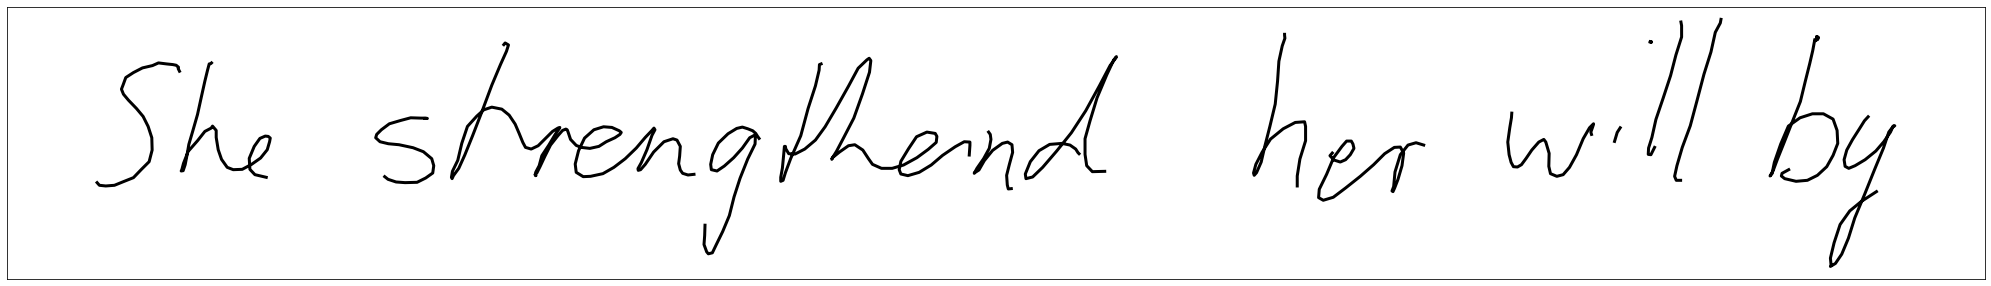

TEXT: She strengthened her will by

TEXT:
Epoch 8/100
5520/5520 [==============================] - 123s 22ms/step - loss: 2.9406e-04 - acc: 0.2229 - val_loss: 2.1502e-04 - val_acc: 0.2304
(915, 3)


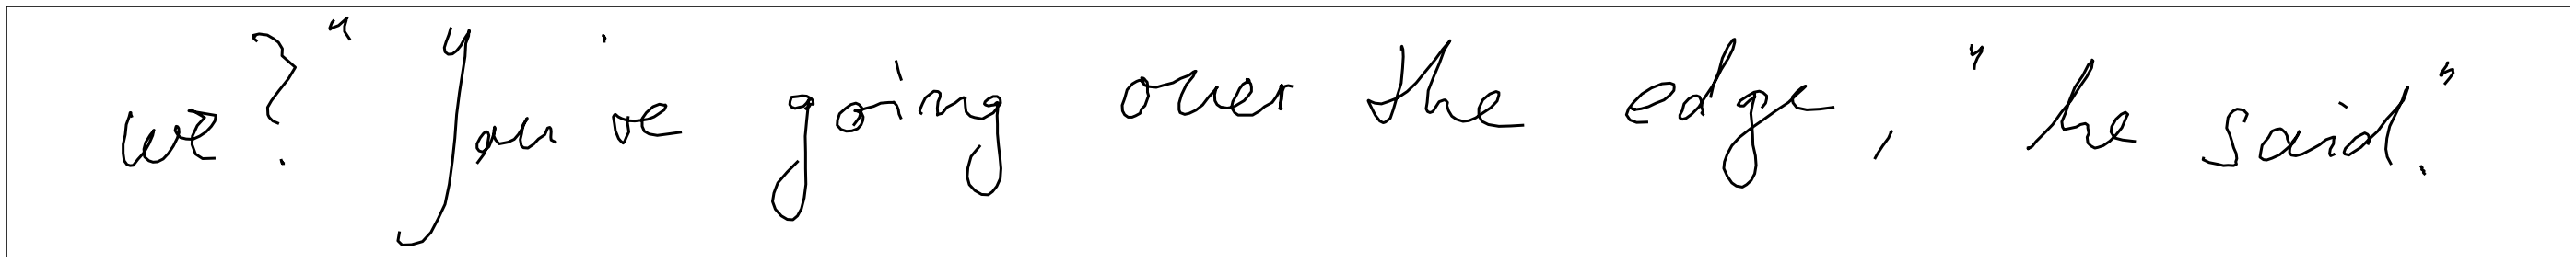

TEXT: me?" You 're going over the edge, "he said."

TEXT:ome?" You 're going over the edge, "he said."
Epoch 9/100
5520/5520 [==============================] - 123s 22ms/step - loss: 2.1603e-04 - acc: 0.2229 - val_loss: 1.6632e-04 - val_acc: 0.2304
(598, 3)


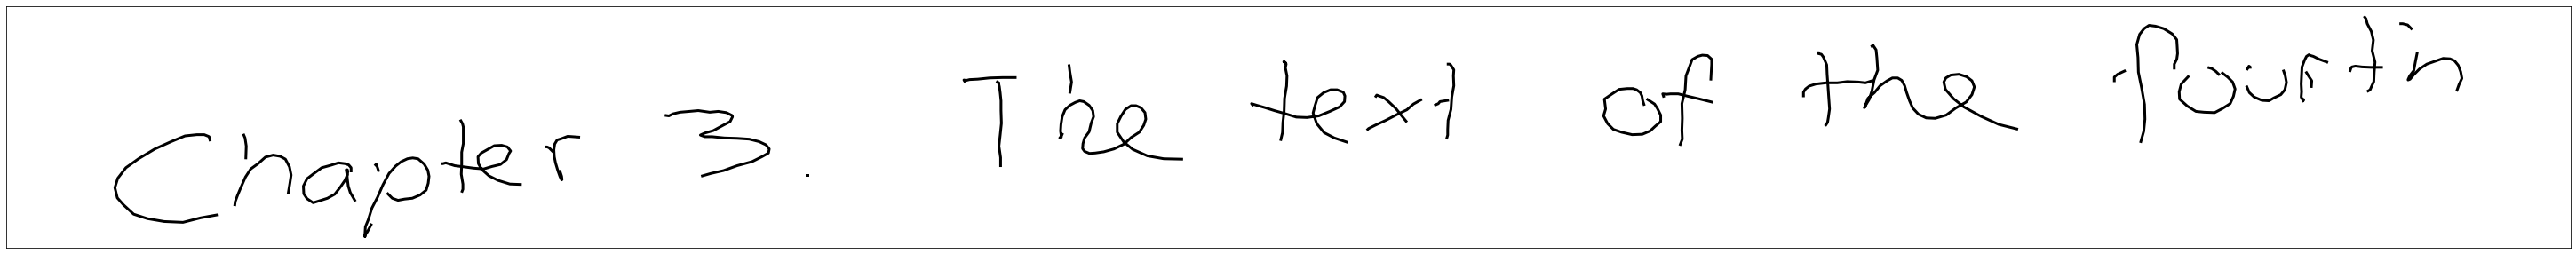

TEXT: Chapter 3. The text of the fourth

TEXT:
Epoch 10/100
5520/5520 [==============================] - 123s 22ms/step - loss: 1.6868e-04 - acc: 0.2229 - val_loss: 1.3494e-04 - val_acc: 0.2304
(945, 3)


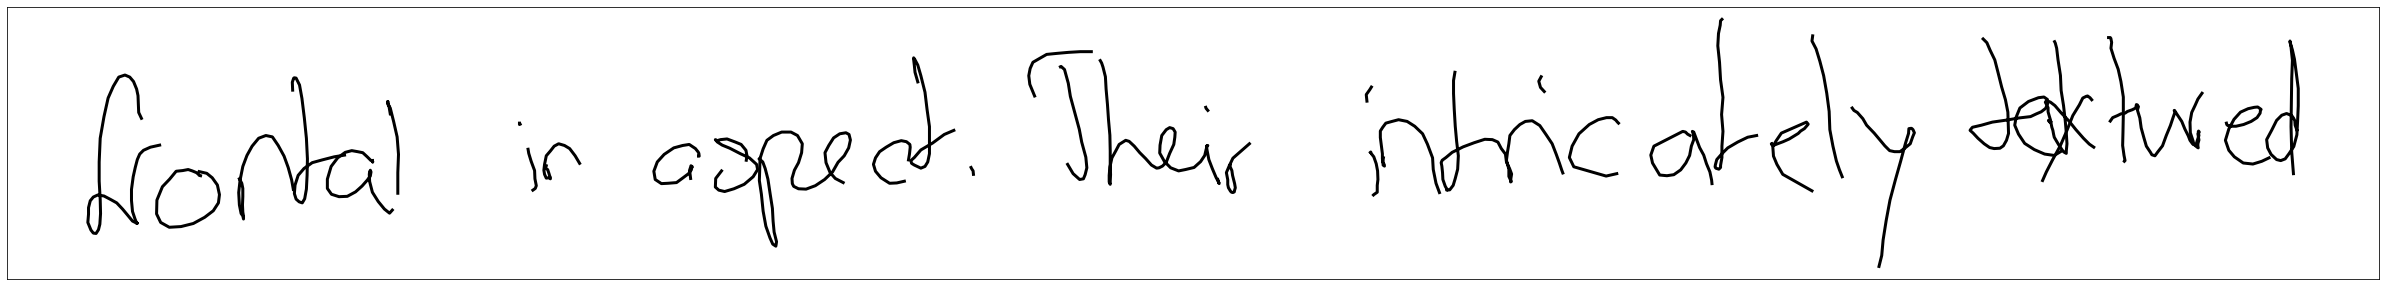

TEXT: frontal in aspect. Their intricately textured

TEXT:ofrontal in aspect. Their intricately textured
Epoch 11/100
5520/5520 [==============================] - 123s 22ms/step - loss: 1.3485e-04 - acc: 0.2229 - val_loss: 1.1251e-04 - val_acc: 0.2304
(556, 3)


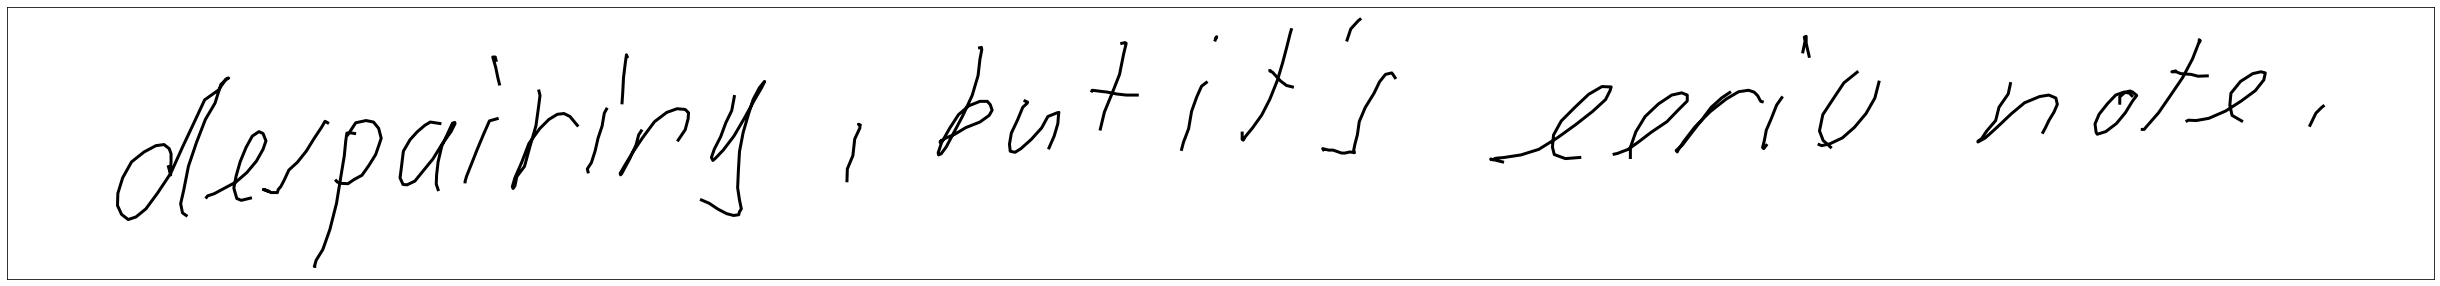

TEXT: despairing; but it's eerie note,

TEXT:adespairing; but it's eerie note,


In [169]:
latent_dim = 300
batch_size = 64
epochs = 100

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder1 = GRU(latent_dim, return_state=True, return_sequences=True)
encoder2 = GRU(latent_dim, return_state=True)
e1 = encoder1(encoder_inputs)
encoder_outputs, state_h = encoder2(e1)

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_gru1 = GRU(latent_dim, return_sequences=True)
decoder_gru2 = GRU(latent_dim, return_sequences=True)
d1 = decoder_gru1(decoder_inputs, initial_state=state_h)
d2 = decoder_gru2(d1)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(d2)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

foldername = f'2-level-gru-{latent_dim}-latent-dim-cropped-inverted-float-in-pre-out-post-2-sigma'
previewer = Previewer(inverted=inverse)
checkpoint = ModelCheckpoint('../models/'+foldername+'weights.{epoch:03d}-val_loss{val_loss:.2f}-val_acc{val_acc:.4f}.hdf5', 
                             monitor='val_loss')
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=5)
tensorboard = TensorBoard(f'../logs/{foldername}')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model.fit([padded_input, decoder_input_data, decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.08,
         callbacks=[previewer, checkpoint, earlyStopping, tensorboard])

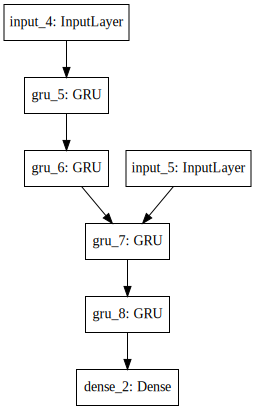

In [41]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Model loading and testing

(755, 3)


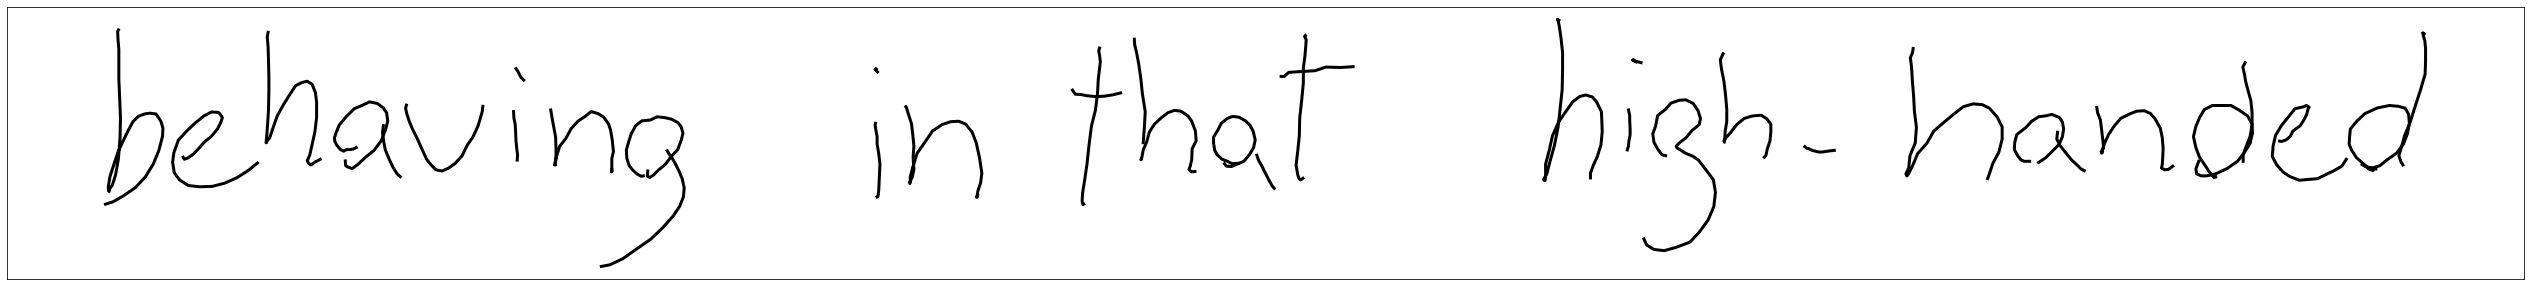

TEXT: behaving in that high-handed

TEXT:abehaving in that high-handed
(458, 3)


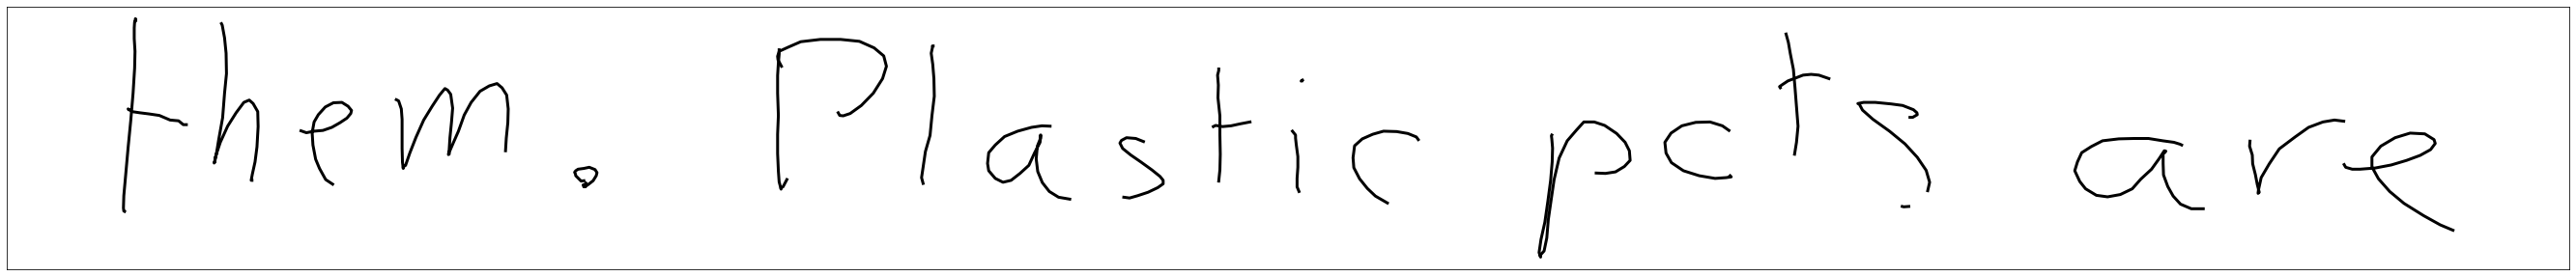

TEXT: them . Plastic pots are

TEXT:athem . Plastic pots are
(686, 3)


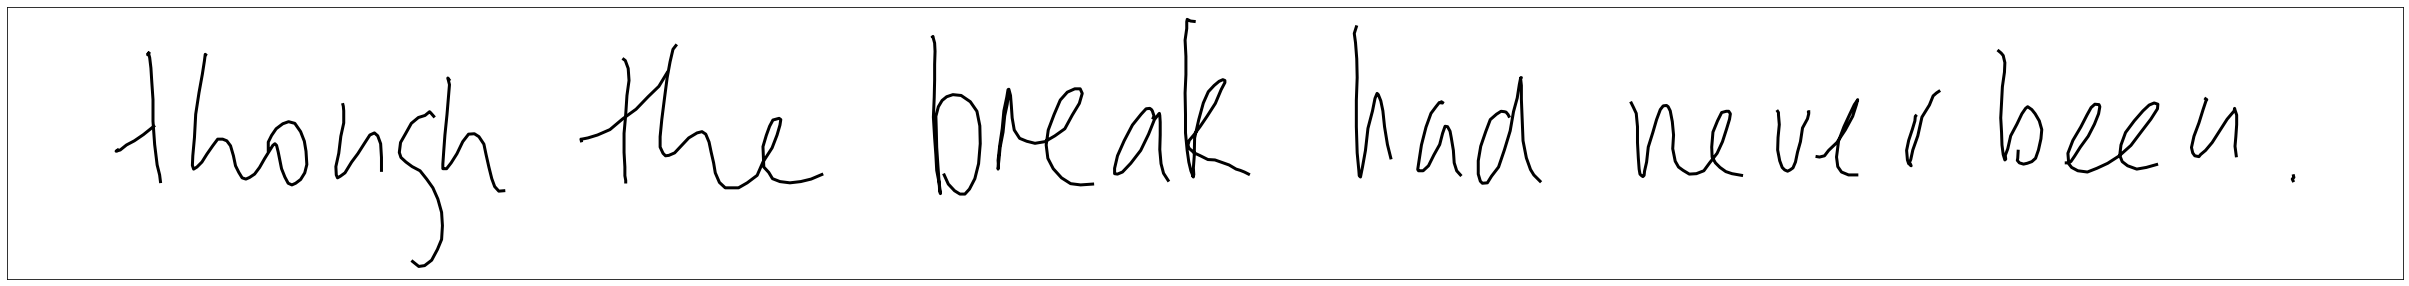

TEXT: though the break had never been.

TEXT:athough the break had never been.
(351, 3)


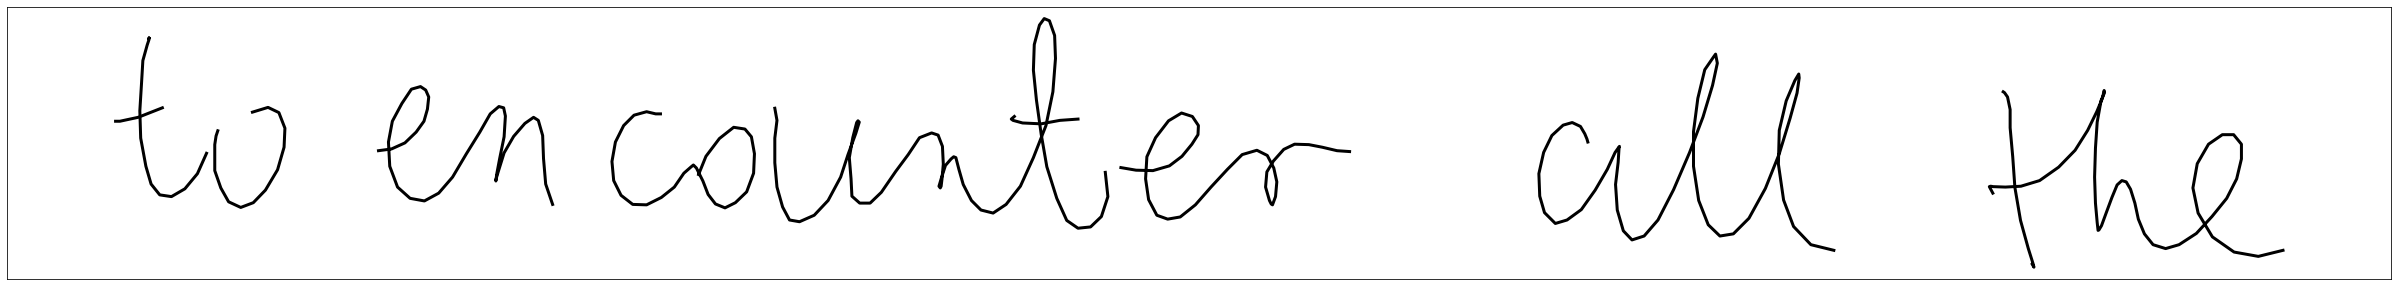

TEXT: to encounter all the

TEXT:ato encounter all the
(687, 3)


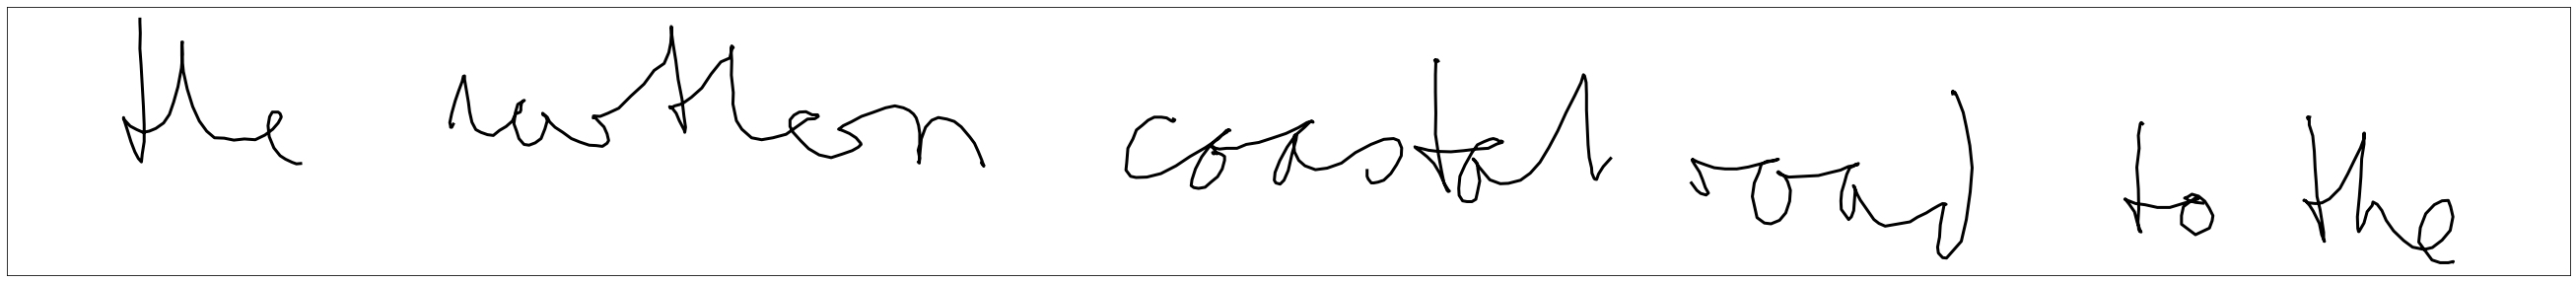

TEXT: the northern coastal road to the

TEXT:athe northern coastal road to the
(700, 3)


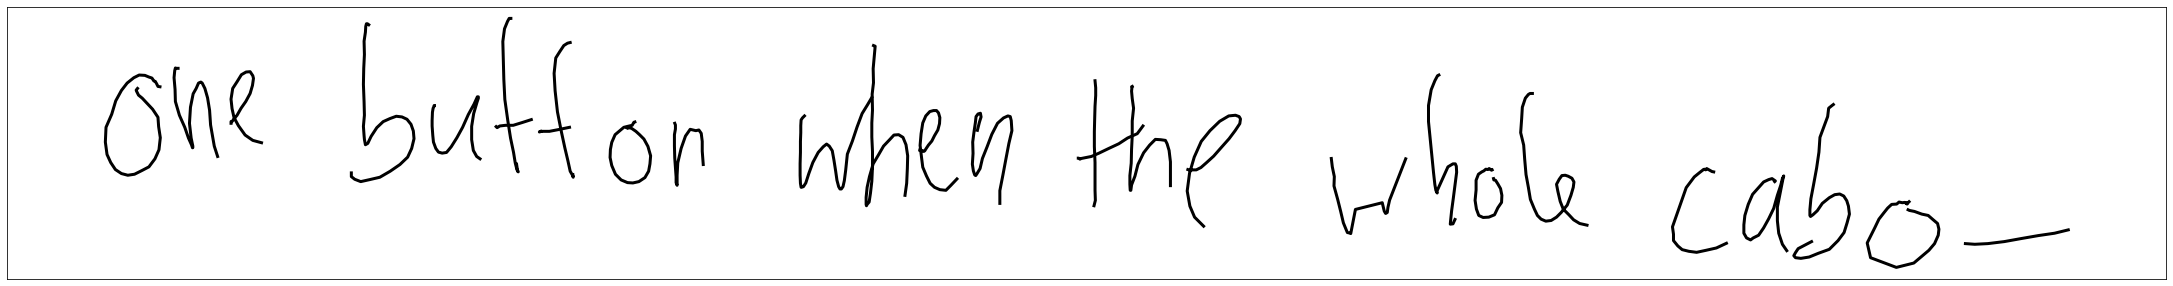

TEXT: one button when the whole cabo-

TEXT:mone button when the whole cabo-
(662, 3)


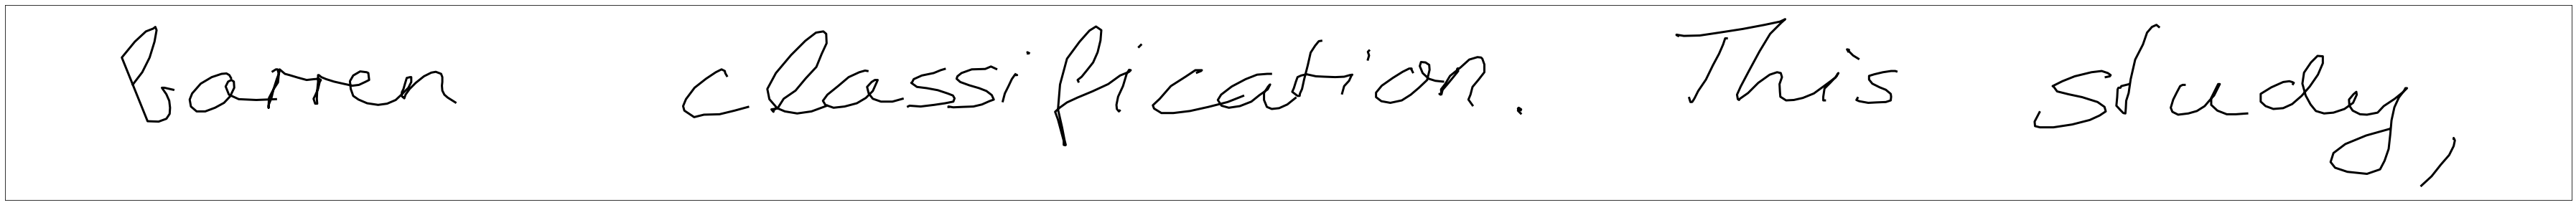

TEXT: barren classification. This study,

TEXT:
barren classification. This study,









(357, 3)


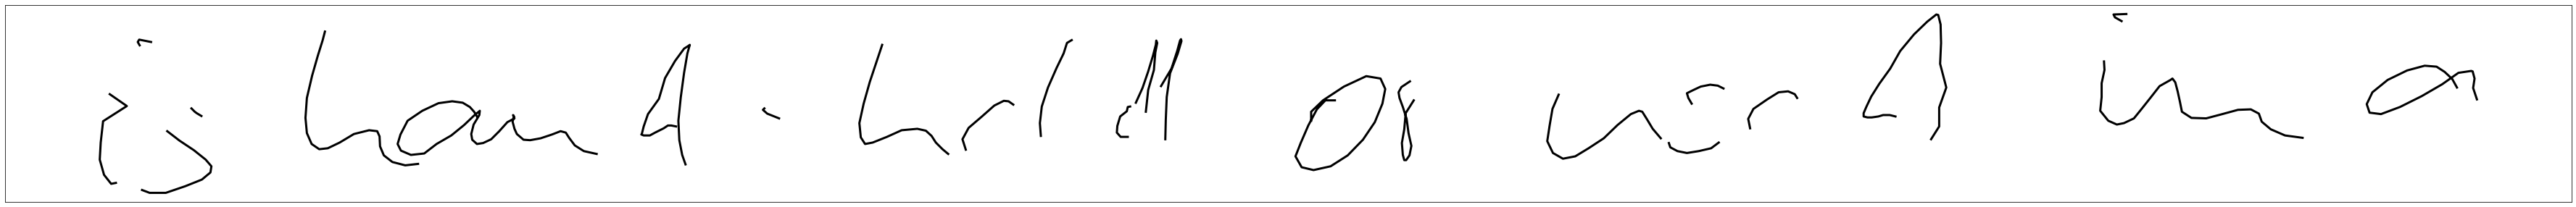

TEXT: is hand-held or used in a

TEXT:ais hand-held or used in a
(373, 3)


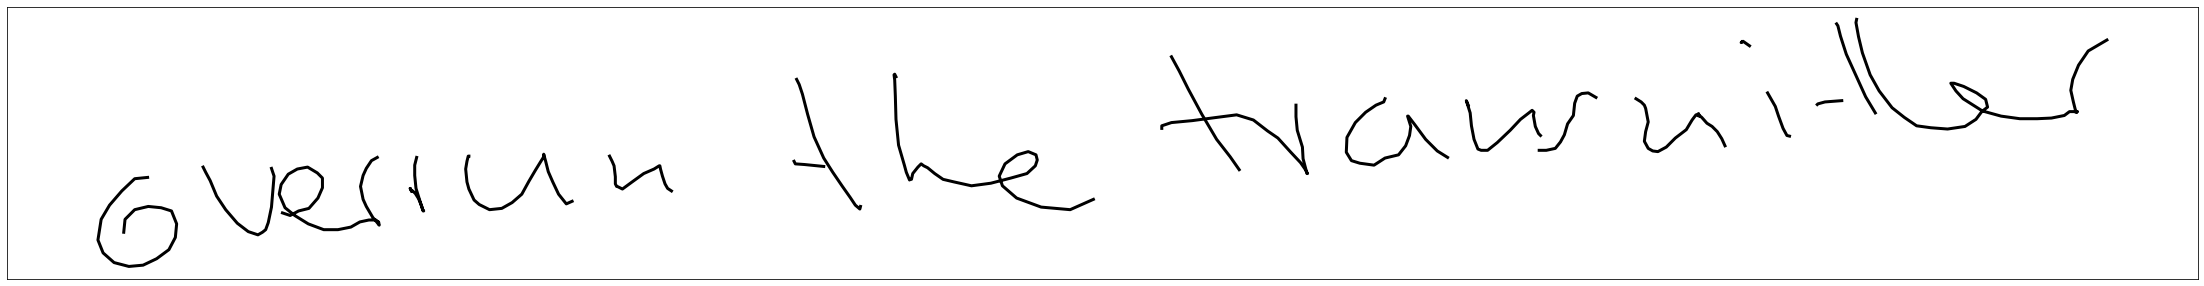

TEXT: overrun the transmitter

TEXT:boverrun the transmitter
(686, 3)


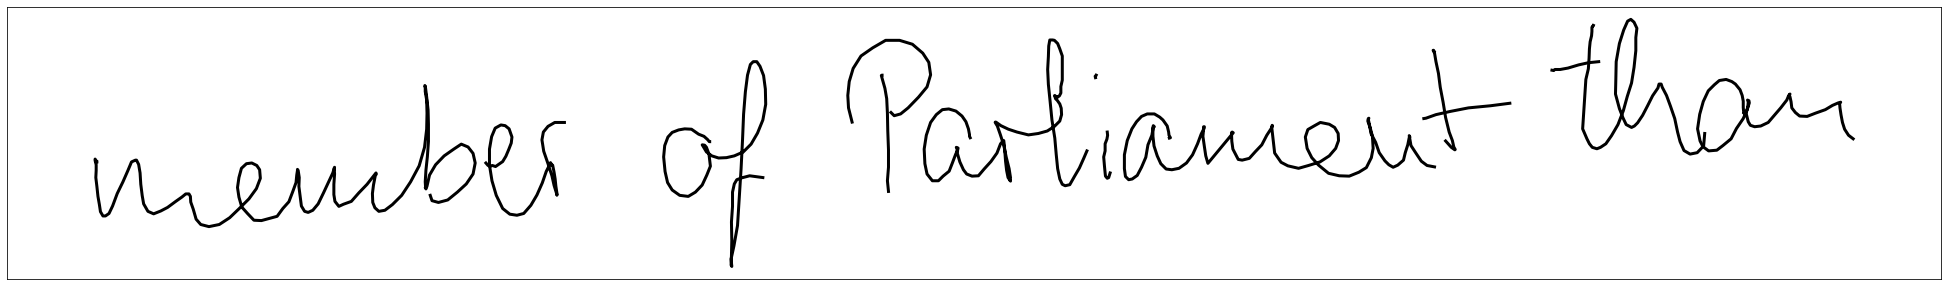

TEXT: member of Parliament than

TEXT:amember of Parliament than
(499, 3)


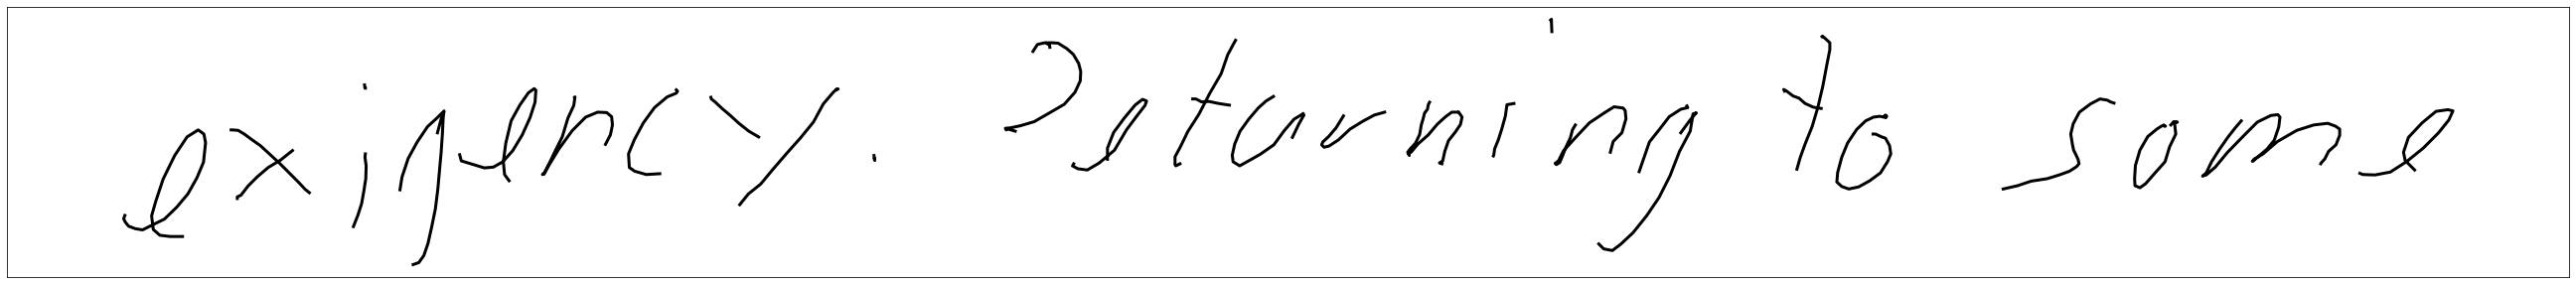

TEXT: exigency. Returning to some

TEXT:bexigency. Returning to some
(688, 3)


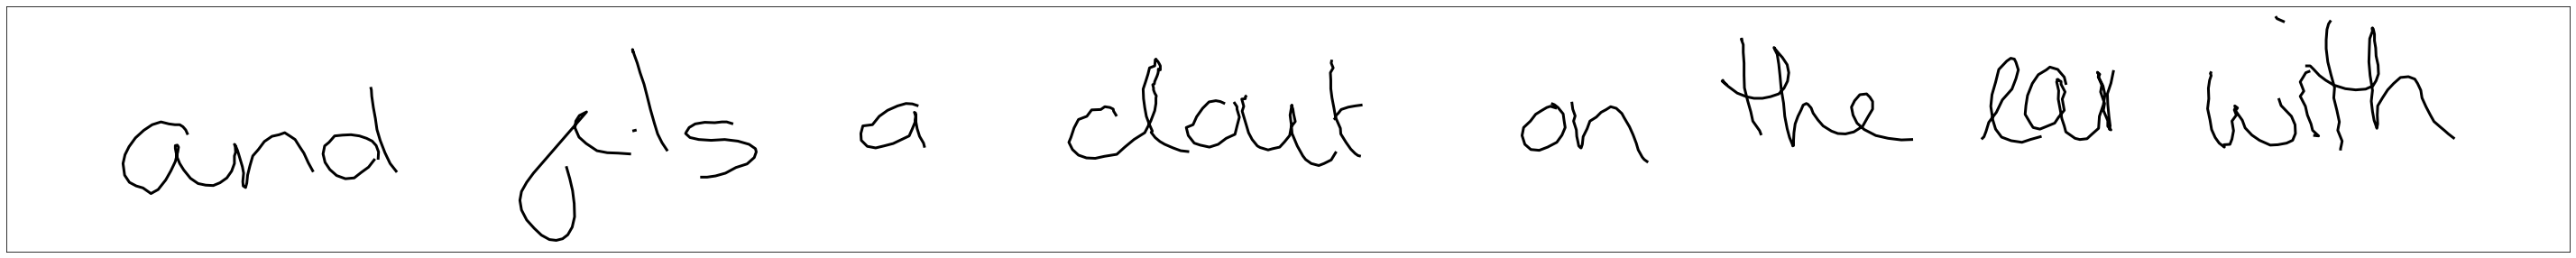

TEXT: and gets a clout on the ear with

TEXT:mand gets a clout on the ear with
(611, 3)


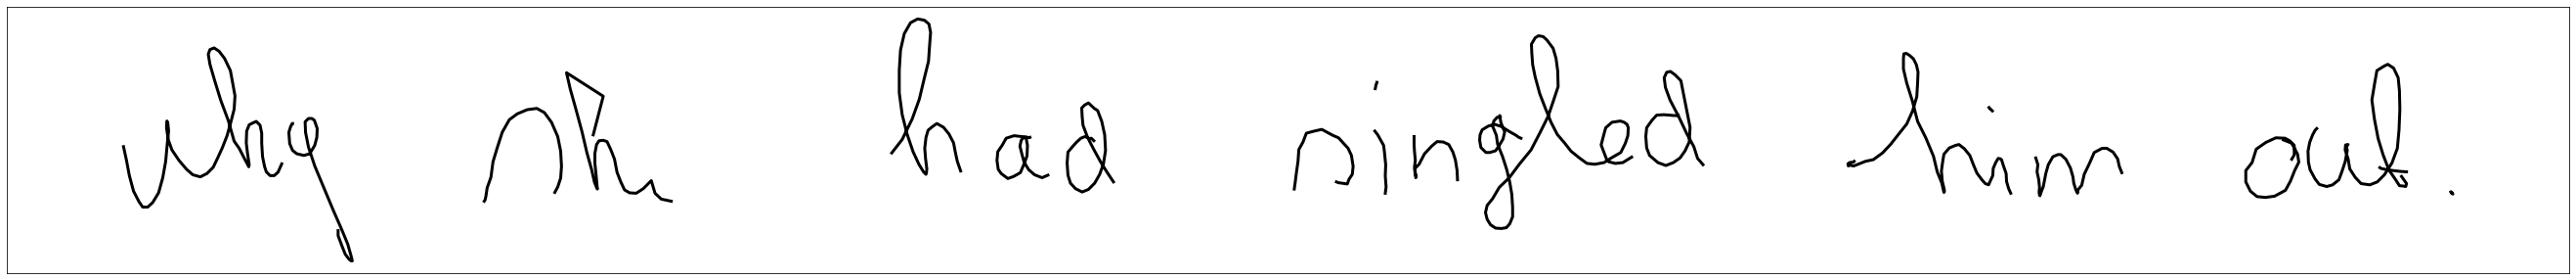

TEXT: why she had singled him out.

TEXT: why she had singled him out.
(660, 3)


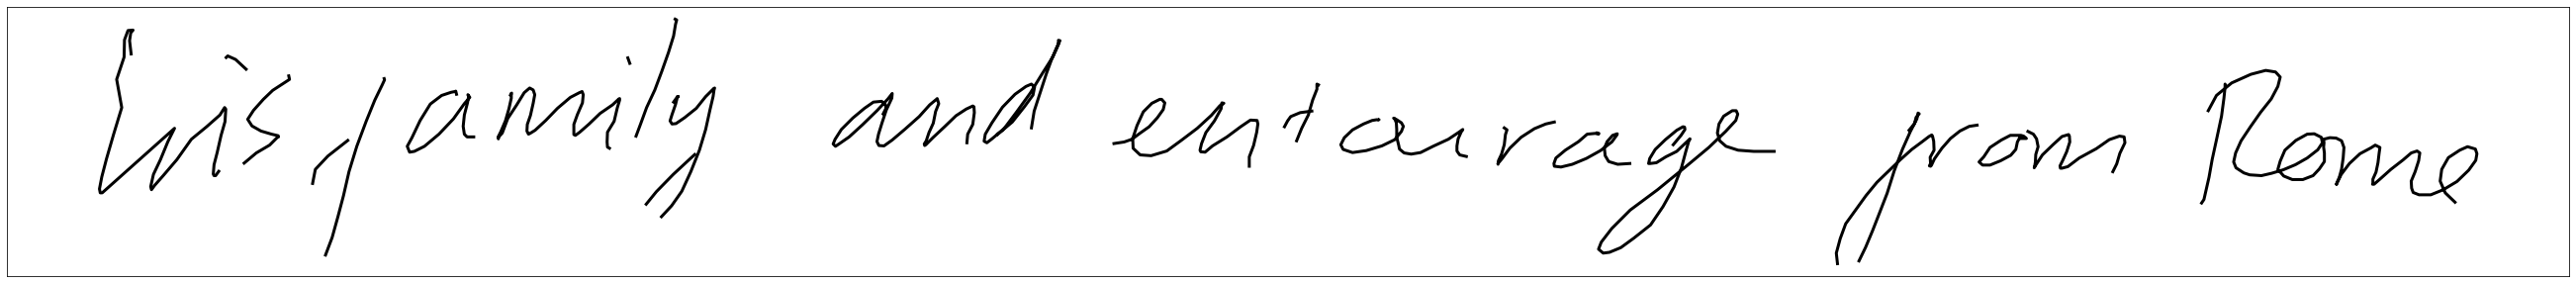

TEXT: his family and entourage from Rome

TEXT:this family and entourage from Rome
(484, 3)


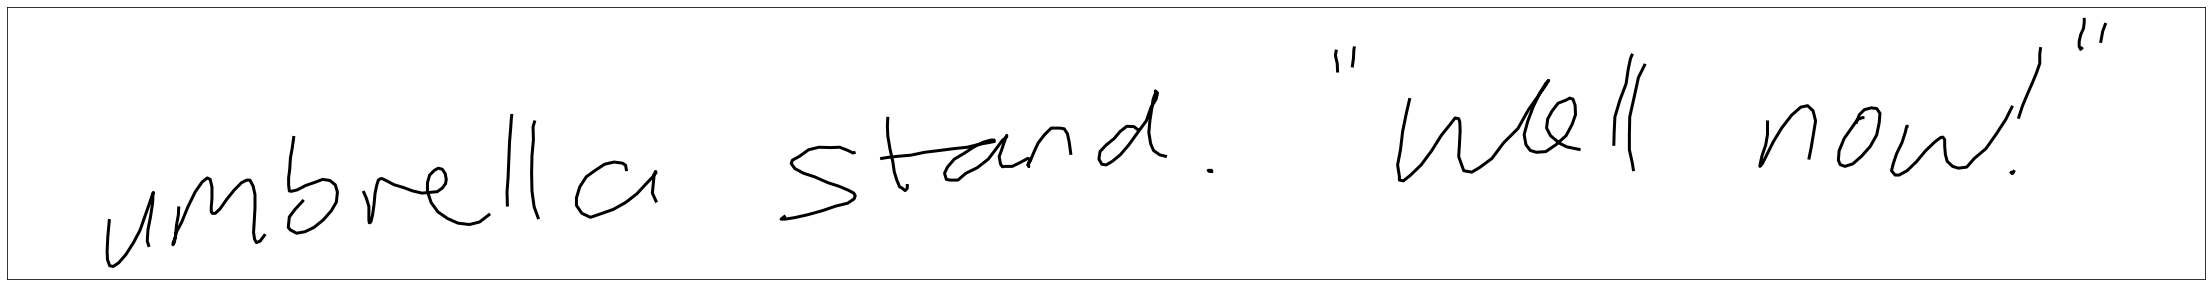

TEXT: umbrella stand. "Well now!"

TEXT:qumbrella stand. "Well now!"
(479, 3)


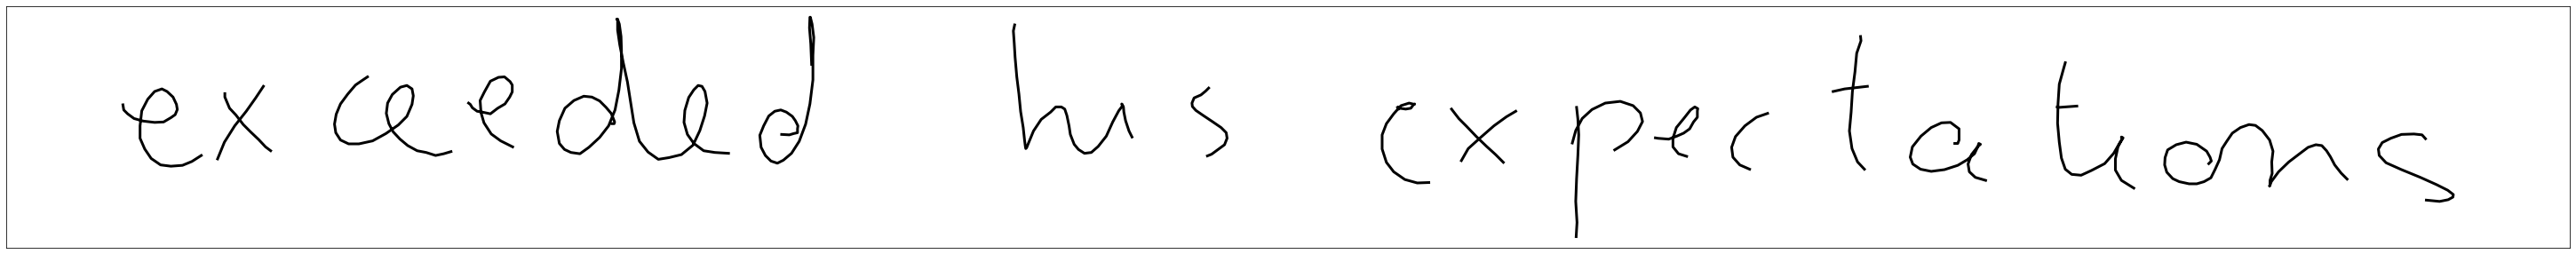

TEXT: exceeded his expectations .

TEXT:bexceeded his expectations .
(1045, 3)


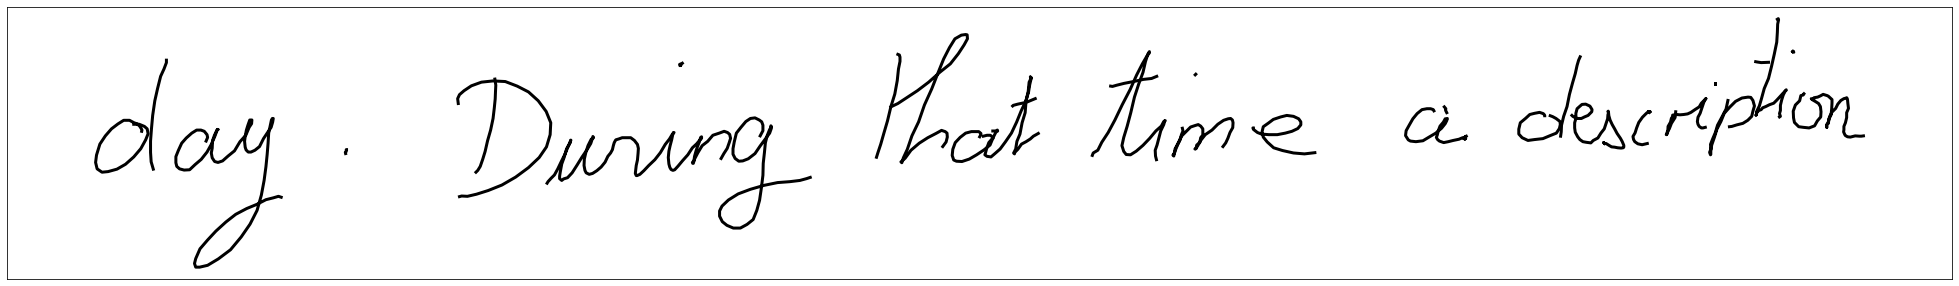

TEXT: day . During that time a description

TEXT:aday . During that time a description
(801, 3)


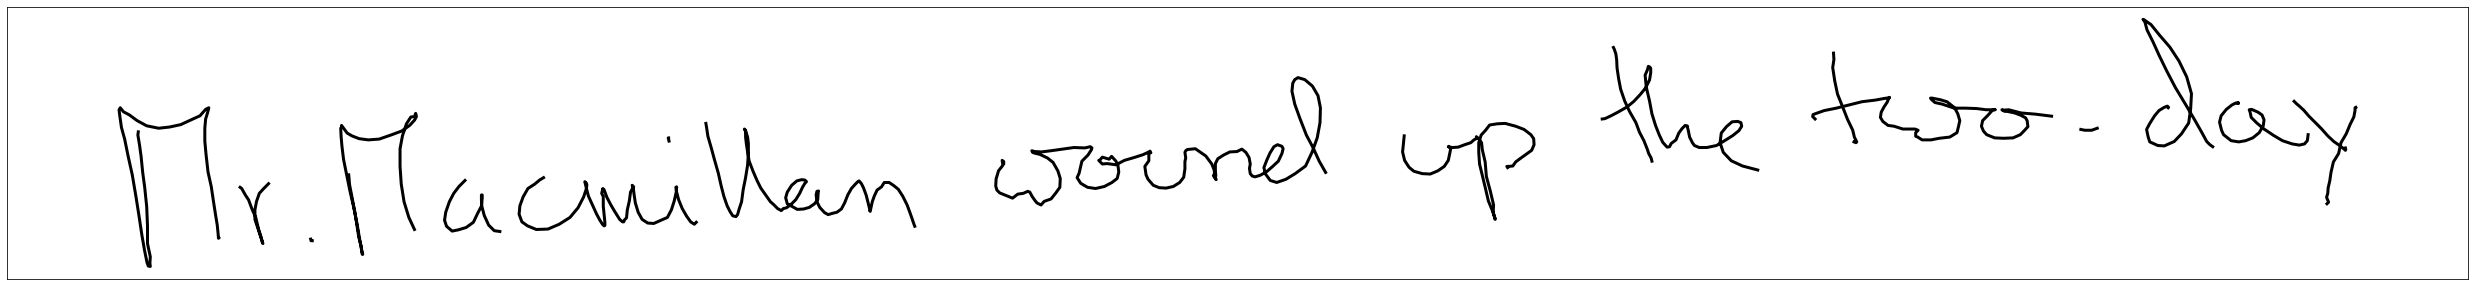

TEXT: Mr. Macmillan wound up the two-day

TEXT:
Mr. Macmillan wound up the two-day









(579, 3)


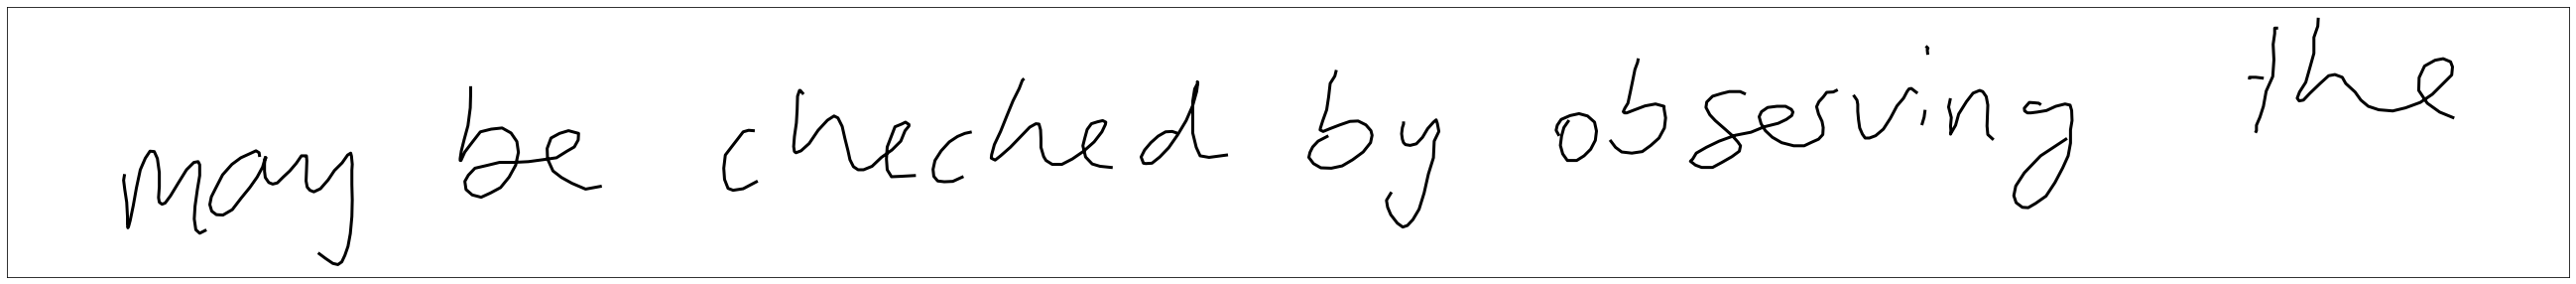

TEXT: may be checked by observing the

TEXT:omay be checked by observing the
(685, 3)


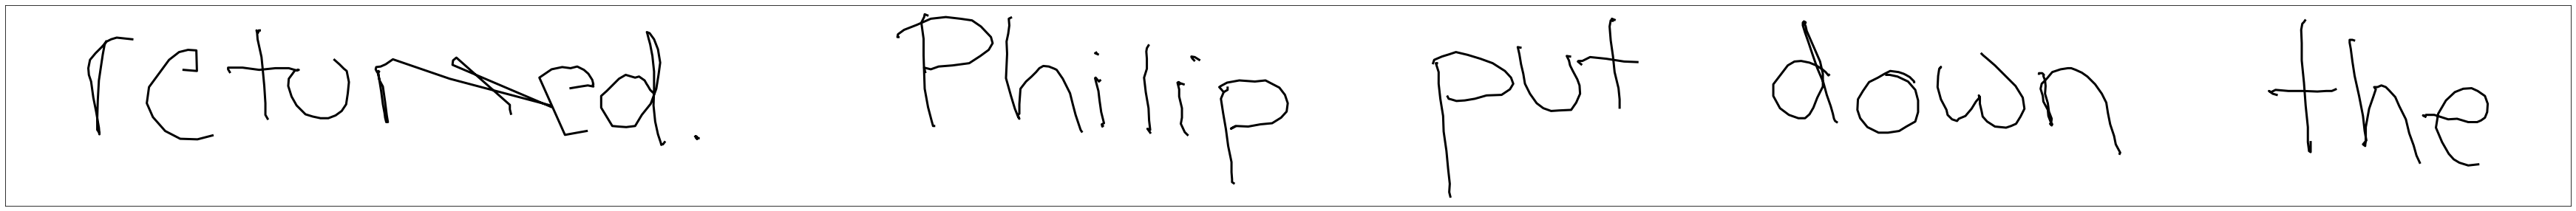

TEXT: returned. Philip put down the

TEXT:areturned. Philip put down the
(821, 3)


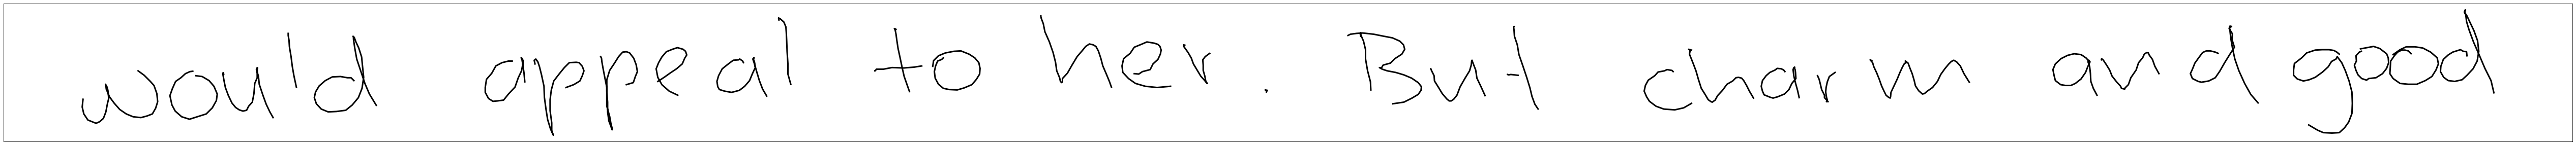

TEXT: would appeal to her. But charm and good

TEXT: would appeal to her. But charm and good
(598, 3)


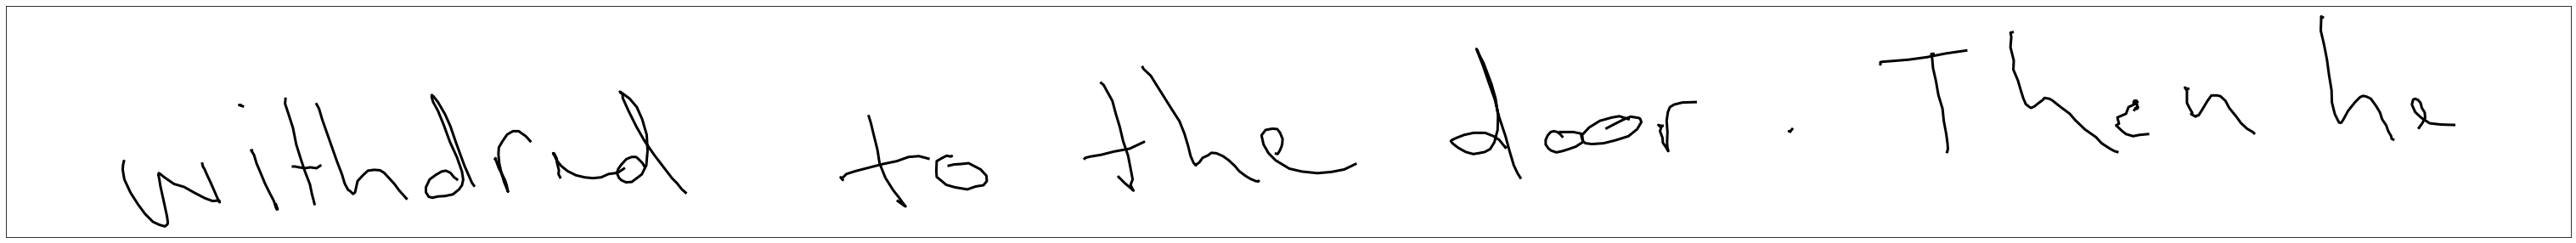

TEXT: withdred to the door. Then he

TEXT: withdred to the door. Then he
(551, 3)


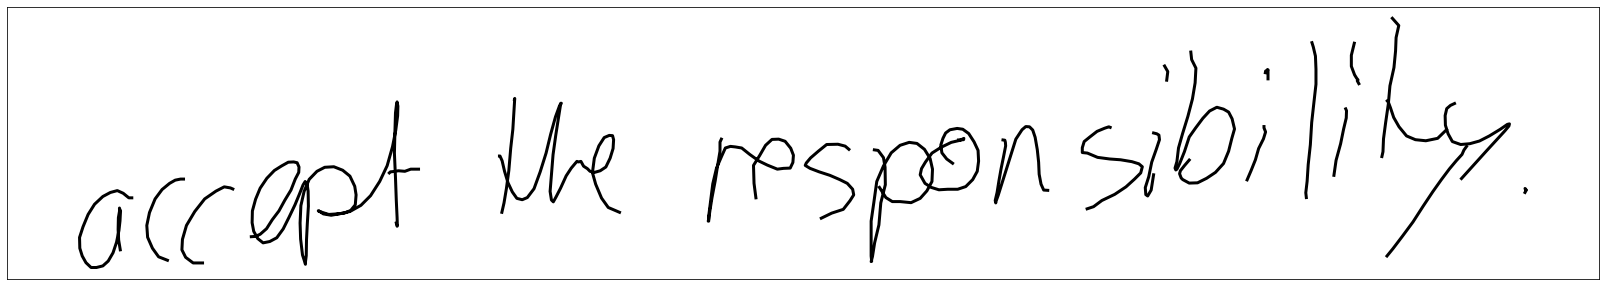

TEXT: accept the responsibility.

TEXT:baccept the responsibility.
(699, 3)


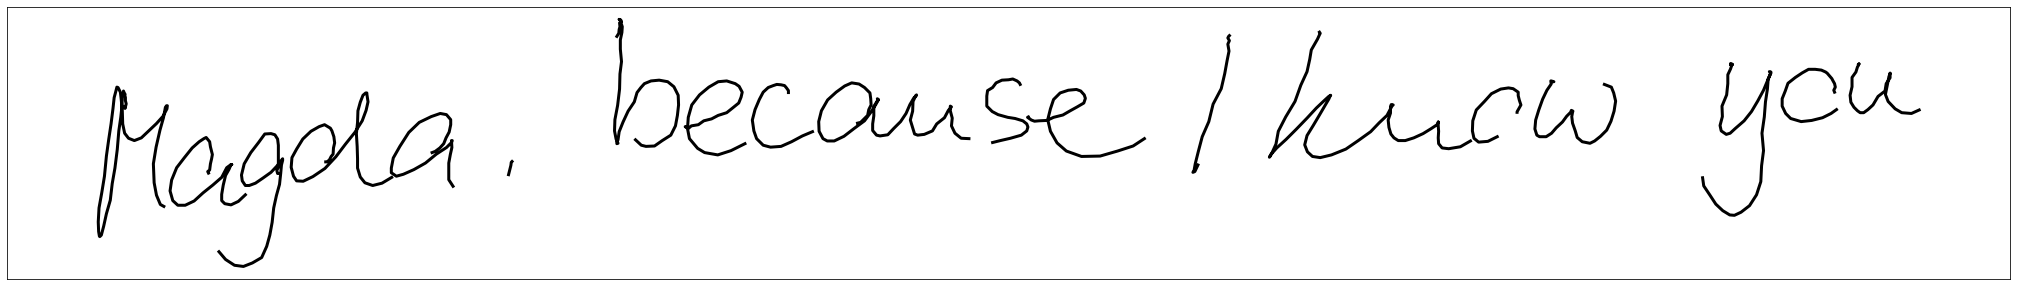

TEXT: Magda, because I know you

TEXT:
Magda, because I know you


















(603, 3)


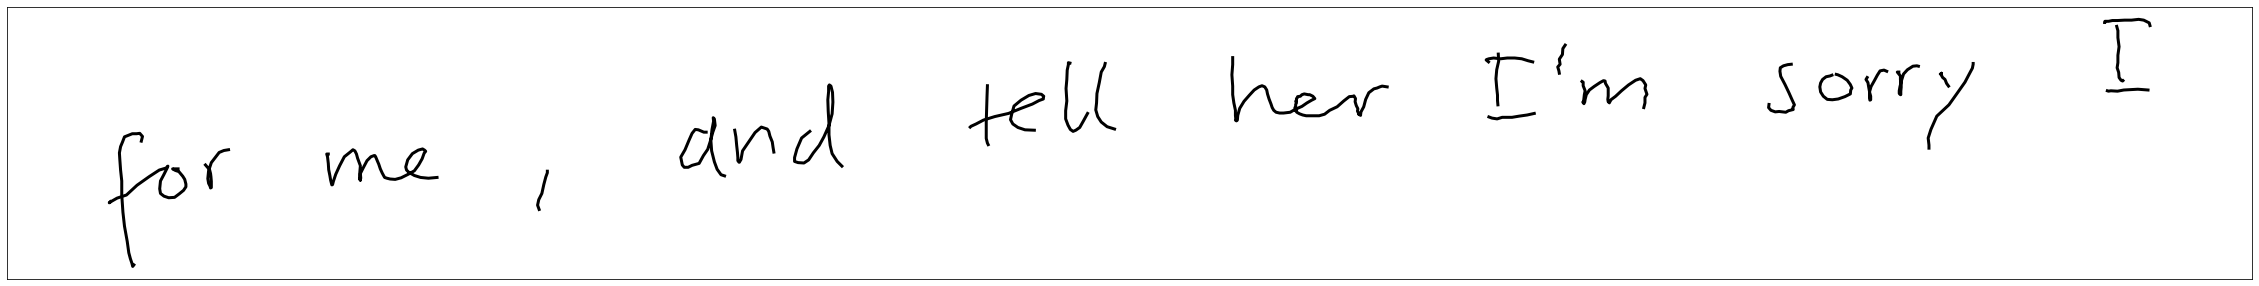

TEXT: for me, and tell her I 'm sorry I

TEXT:ofor me, and tell her I 'm sorry I
(416, 3)


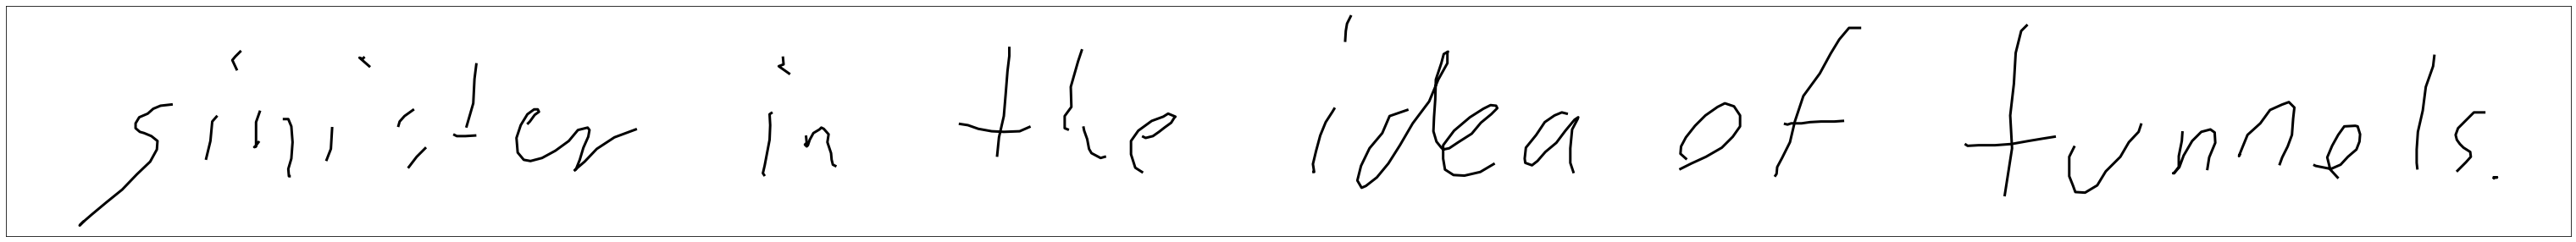

TEXT: sinister in the idea of tunnels.

TEXT:asinister in the idea of tunnels.
(492, 3)


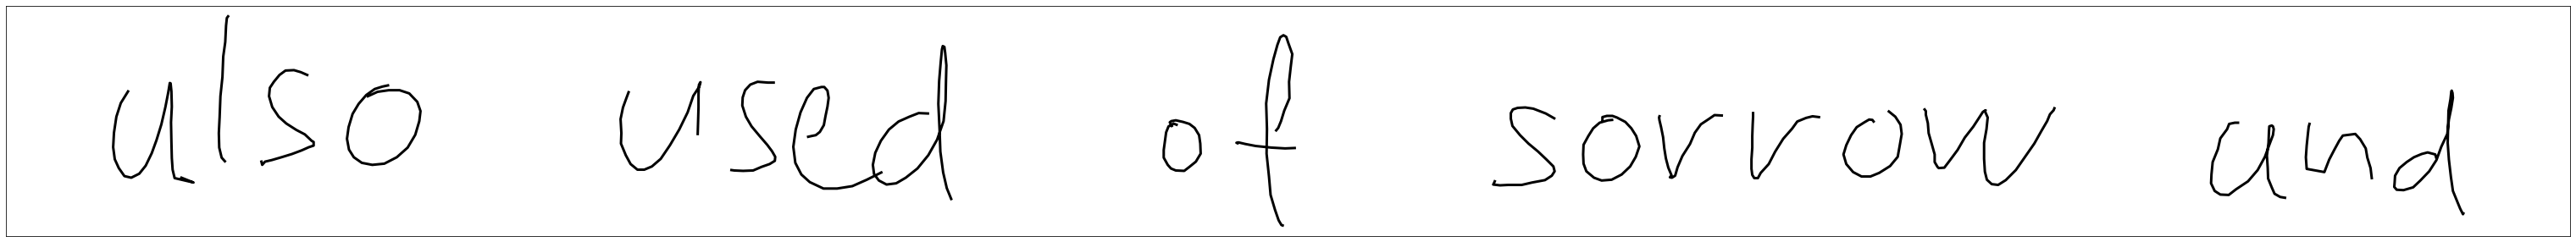

TEXT: also used of sorrow and

TEXT:balso used of sorrow and
(853, 3)


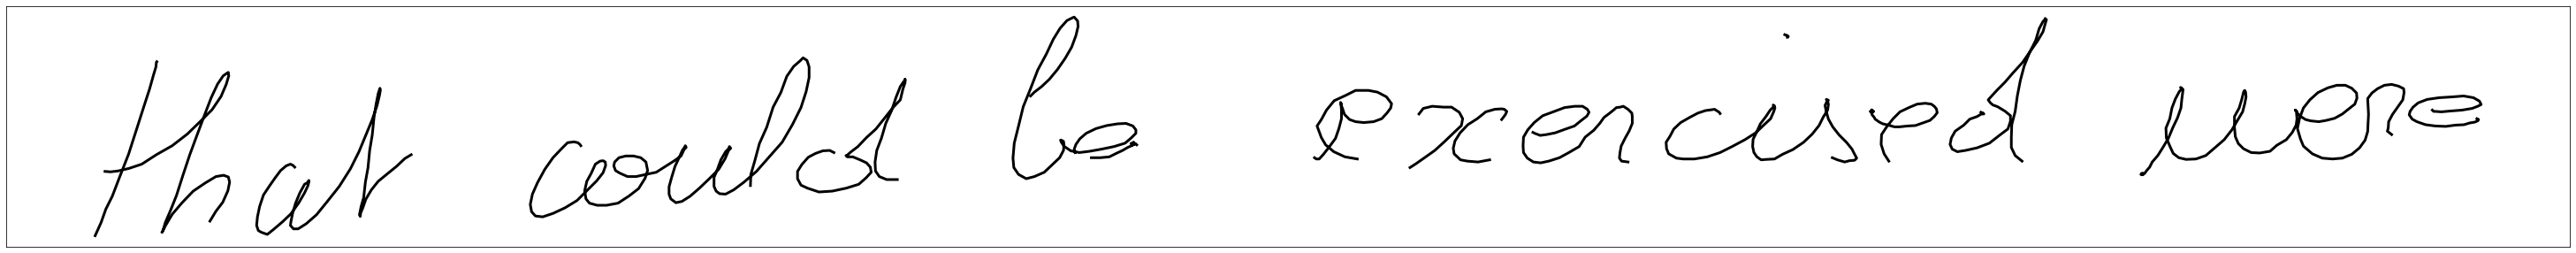

TEXT: than could be exercised were

TEXT:athan could be exercised were
(739, 3)


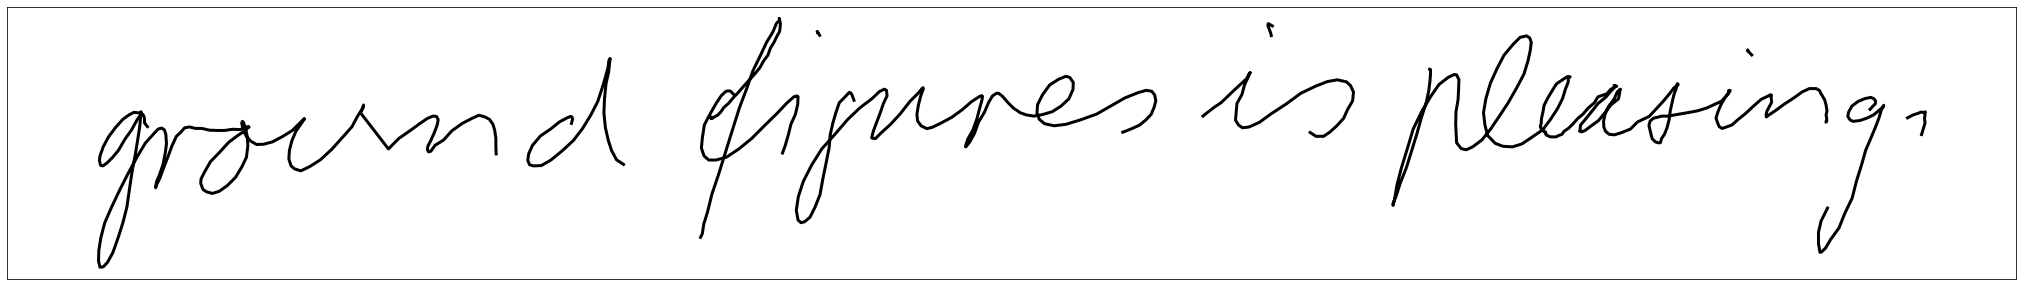

TEXT: ground figures is pleasing,

TEXT:nground figures is pleasing,
(649, 3)


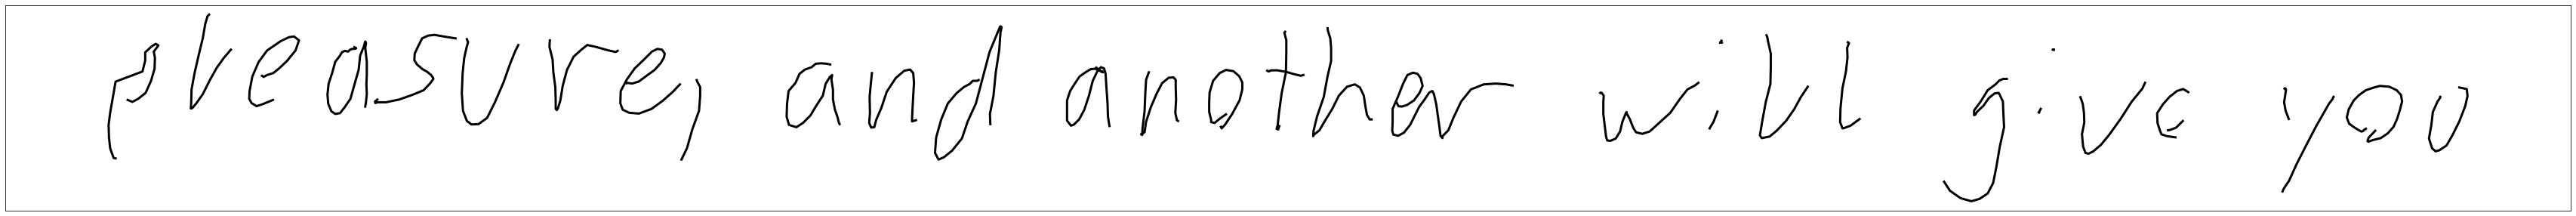

TEXT: pleasure, and another will give you

TEXT:
pleasure, and another will give you










In [491]:
n_previews = 10
model_test = load_model('../models/2-level-gru-300-latent-dim-cropped-inverted-float-in-pre-out-post-2-sigmaweights.005-val_loss0.00-val_acc0.2304.hdf5')
for i in range(n_previews):
    idx = np.random.randint(low=0,high=len(strokes))
    predictions = model_test.predict([[padded_input[idx]], [decoder_input_data[idx]]])
    stroke = strokes[idx]
    print(stroke.shape)
    text = texts[idx]
    plot_stroke(stroke)
    print('TEXT:', text)
    sequence = []
    for l in predictions[0]:
        sequence.append(np.argmax(l))
    sequence = np.flip(np.array(sequence))
    predicted = tokens_to_string(sequence)
    if predicted.find('\n') > -1 and predicted.find('\n') > 10:
        print("TEXT:{}".format(predicted[:predicted.index('\n')]))
    else:
        print("TEXT:{}".format(predicted))

# Generate Strokes